In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import scipy.ndimage
import dearpygui.dearpygui as dpg
import dearpygui.demo as demo
from rembg import remove
from PIL import Image
import keras_ocr
import collections
import pdf2image
from pdf2image import convert_from_path

Конвертация файла pdf со стандартизированным сканированием в подборку изображений для текстовой сегментации (формат png)
Для проверки работы на стандартизированном варианте изображений

In [ ]:
#pip install poppler-utils
#pip install pdf2image
#https://github.com/oschwartz10612/poppler-windows/releases/ get zip file of poppler for windows and unzip it to the path

In [ ]:
images = convert_from_path('bx000026438.pdf', poppler_path= r'C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\Release-21.11.0-0\poppler-21.11.0\Library\bin')
 
for i in range(len(images)):
      # сохранить изображению из pdf
    images[i].save('page'+ str(i) +'.png', 'PNG')

In [37]:
# output_path = os.mkdir(r'C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\rem_bg')
# textrem_path = os.mkdir(r'C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\rem_text')

In [2]:
img_path = r'C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\png'
output_path = r'C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\rem_bg'
filename = r"C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\png\page6.png" #TEST PATH
textrem_path = r'C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\rem_text'

ВЫРАВНИВАНИЕ ГИСТОГРАММЫ ИЗОБРАЖЕНИЯ В ОТТЕНКАХ СЕРОГО И УДАЛЕНИЕ ФОНА ИЗОБРАЖЕНИЯ (ФОРМАТ PNG)

In [3]:
# ВЫРАВНИВАНИЕ ГИСТОГРАММЫ изображения в оттенках серого
# Рассчитываем гистограмму изображения 
def draw_histogram(grayscale):
    gray_key = []
    gray_count = []
    gray_result = []
    histogram_gray = list(grayscale.ravel())  # Преобразование многомерного массива в одномерный массив
    gray = dict(collections.Counter(histogram_gray))  # Подсчитать количество вхождений каждого уровня серого в изображении
    gray = sorted(gray.items(), key=lambda item: item[0])  # Сортировать по размеру серой шкалы
    for element in gray:
        key = list(element)[0]
        count = list(element)[1]
        gray_key.append(key)
        gray_count.append(count)
    for i in range(0, 256):
        if i in gray_key:
            num = gray_key.index(i)
            gray_result.append(gray_count[num])
        else:
            gray_result.append(0)
    gray_result = np.array(gray_result)
    return gray_result

def histogram_equalization(histogram_e, lut_e, image_e):
    sum_temp = 0
    cf = []
    for i in histogram_e:
        sum_temp += i
        cf.append(sum_temp)
    for i, v in enumerate(lut_e):
        lut_e[i] = int(255.0 * (cf[i] / sum_temp) + 0.5)
    equalization_result = lut_e[image_e]
    return equalization_result

def main_hist():
    x = []
    for i in range(0, 256):  # Abscissa
        x.append(i)

    image = cv2.imread(filename, cv2.COLOR_BGR2GRAY)  # чтение изображения
    histogram = draw_histogram(image)  # применение функции вычисления гистограммы
    plt.bar(x, histogram)  #вывод графика исходной гистограммы
    plt.savefig('before_histogram.png')
    plt.show()

    lut = np.zeros(256, dtype=image.dtype)  # Создать пустую таблицу изображения и вернуть массив типа изображения, заполненный 0;
    result = histogram_equalization(histogram, lut, image)  # Вызов функции выравнивания
    cv2.imwrite('his_grey.png', result)  # Сохранить сбалансированное изображение

    image_equ = cv2.imread(r'his_grey.png', cv2.COLOR_BGR2GRAY)  # Читаем изображение
    histogram_equ = draw_histogram(image_equ)  # Преобразование гистограммы
    plt.bar(x, histogram_equ)  # Рисуем гистограмму обработанного изображения
    plt.savefig('after_histogram.png')
    plt.show()

    plt.plot(x, lut)  # График кривой преобразования серой шкалы
    plt.savefig('Grayscale_transformation_curve.png')
    plt.show()

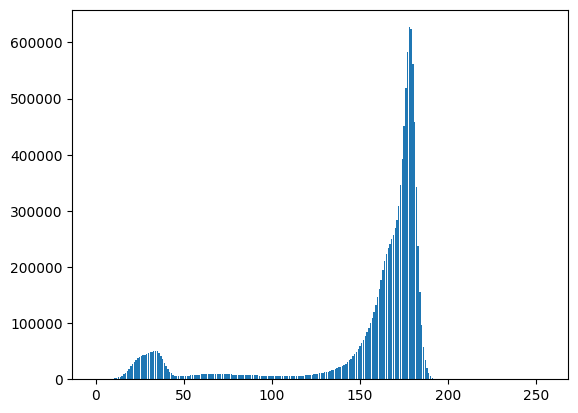

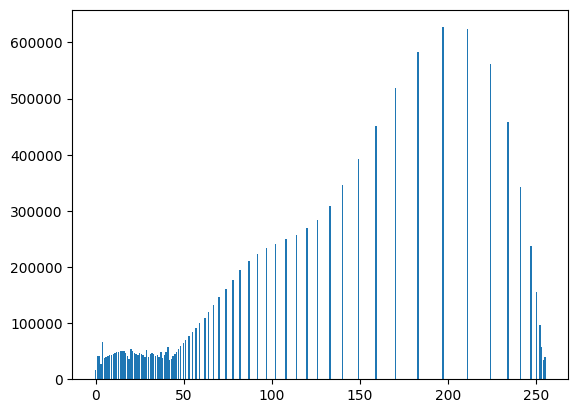

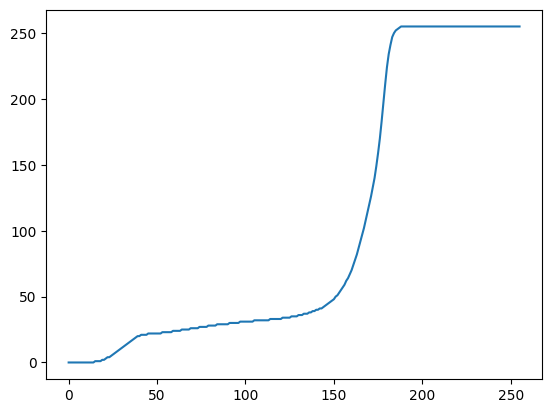

In [4]:
# main_hist()

In [10]:
# ----- MAIN BG-REMOVING
# Удаление фона изображения с помощью bgrem (пакетная обработка изображений в директории)

def remove_background(img_path):
    # создаем директорию для очищеных от фона изображений
    for filename in os.listdir(img_path): #для каждого изображения в директории png
        if filename.lower().endswith(".png"):
            input = Image.open(f'{img_path}\{filename}') #открыть изображение
            output = remove(input) #удалить фон картинки
            saving = output.save(f'{output_path}\{filename}')
            return saving #сохранить изображение в директории


In [ ]:
# output_path = os.mkdir(r'C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\rem_bg') 
# filename = r"C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\png\img_grey.png"

In [11]:
filepath2 = r"C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\png"

remove_background(filepath2)

In [18]:
preprocess_img = Image.open(r'C:\Users\ksuloko\Desktop\RGB\FindDamage\TEXT_REMOVE\test_scan_img\rem_bg\his_grey.png')

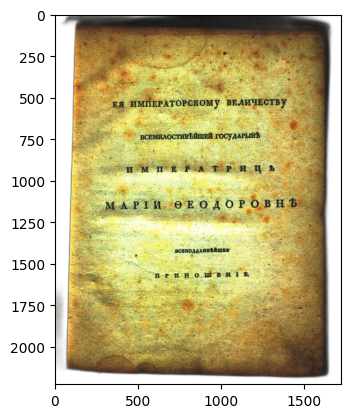

In [19]:
plt.imshow(preprocess_img)

УДАЛЕНИЕ ТЕКСТА ИЗ ИЗОБРАЖЕНИЯ С ПОМОЩЬЮ OCR

In [20]:
# -----OCR KERAS-----
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

pipeline = keras_ocr.pipeline.Pipeline()

def inpaint_text(img_path, pipeline):
    # чтение изображение
    img = keras_ocr.tools.read(img_path)
    # генерируем bbox для отдельных слов - кортежи
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(img)

Looking for C:\Users\ksuloko\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\ksuloko\.keras-ocr\crnn_kurapan.h5


In [21]:
# удаление текста для пакетной обработки из директории в другую директорию
def rem_text(img_path):
    for filename in os.listdir(img_path):
        finish_img = inpaint_text(f'{img_path}\{filename}', pipeline)
        saver = cv2.imwrite(f'{textrem_path}\{filename}', finish_img)
    return(saver)

In [30]:
# удаление фона изображений и сохранение этого в отдельном пути
# remove_background(img_path)

In [23]:
# Вызов функции стирания текста в KERAS OCR (работает очень долго)
# finish_img = inpaint_text(filename, pipeline)

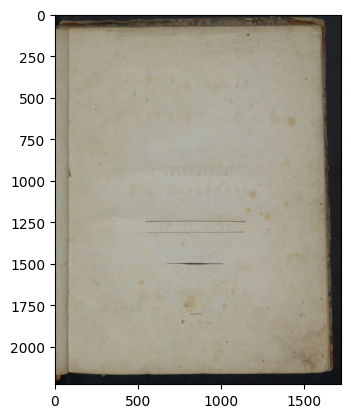

In [36]:
# plt.imshow(finish_img)

In [45]:
# rem_text(img_path)

1/1 [==============================] - 28s 28s/step


True